epoch: 0, cost: 102.359322
epoch: 5, cost: 10.870509
epoch: 10, cost: 3.986809
epoch: 15, cost: 2.118483
epoch: 20, cost: 1.189271
epoch: 25, cost: 0.768679
epoch: 30, cost: 0.566767
epoch: 35, cost: 0.464351
epoch: 40, cost: 0.411508
epoch: 45, cost: 0.383403
epoch: 50, cost: 0.366695


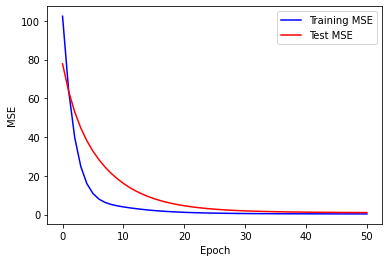

In [2]:
import torch
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt

# pandas : Python Data Analysis Library
# read_csv(filepath, separate:구분자, names:column에 이름 부여)
train = pd.read_csv("./ml-100k/ua.base", sep="\t", names=['user', 'movie', 'rating', 'timestamp'])
test = pd.read_csv("./ml-100k/ua.test", sep="\t", names=['user', 'movie', 'rating', 'timestamp'])

items = torch.LongTensor(train['movie'])
users = torch.LongTensor(train['user'])
ratings = torch.LongTensor(train['rating'])
items_test = torch.LongTensor(test['movie'])
users_test = torch.LongTensor(test['user'])
ratings_test = torch.LongTensor(test['rating'])

rank = 100 # factor의 개수

numItems = items.max() # 1682
numUsers = users.max() # 943

P = torch.randn(numItems + 1, rank, requires_grad=True) # index가 0부터 시작해서 +1 해줌
Q = torch.randn(numUsers + 1, rank, requires_grad=True)

lambda1 = 0.0001

bias_item = torch.randn(numItems + 1, requires_grad=True) # index가 0부터 시작해서 +1 해줌
bias_user = torch.randn(numUsers + 1, requires_grad=True)

mean = (ratings.sum() / len(ratings)).item() #.item()은 값만 가져옴

# learning algorithm
optimizer = torch.optim.Adam([P, Q, bias_item, bias_user], lr=0.1)

X = []
Y = []
Y_test = []

for epoch in range(51):
    # 가설 = 예상 점수
    hypothesis = torch.sum(P[items] * Q[users], dim=1) + mean + bias_item[items] + bias_user[users]
    
    # 오차 계산
    cost = F.mse_loss(hypothesis.to(torch.float32), ratings.to(torch.float32))
    # loss function
    loss = cost + lambda1 * (torch.sum(P ** 2) + torch.sum(Q ** 2) + torch.sum(bias_item ** 2) + torch.sum(bias_user ** 2))
    
    optimizer.zero_grad() # gradients 값들이 계속 누적 되기 때문에 초기화
    loss.backward() # 기울기 계산
    optimizer.step() # 매개변수 조정
    
    # 기울기 계산 하지 않음
    with torch.no_grad():
        hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1) + mean + bias_item[items_test] + bias_user[users_test]
        cost_test = F.mse_loss(hypo_test.to(torch.float32), ratings_test.to(torch.float32))
    
        X.append(epoch)
        Y.append(cost)
        Y_test.append(cost_test)
    
    if epoch % 5 == 0:
        print("epoch: {}, cost: {:.6f}" .format(epoch, cost.item()))
        
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X,Y, c="blue", label="Training MSE")
plt.plot(X,Y_test, c="red", label="Test MSE")
plt.legend()
plt.show()
